# For the presentation

Use your generated dataset and __provide some “interesting” insights__ from the obtained data. For example, you can show which directors/actors participate most in the top 250 movies, or whether the number of received awards correlates with the BoxOffice/Gross value, etc. To this end, you can also incorporate further data, such as the number of awards for the directors and/or actors. 

You can also use __LinkedMDB__ for integrating additional information
> They are offline, but the latest RDF dump is here: http://www.cs.toronto.edu/~oktie/linkedmdb/. Use RDFLib to load that dataset and to query the graph for additional information


Intersting insights can be for example, 
- Which directors/actors participate most in the top 250 movies? 
- Does the number of received awards correlate with the BoxOffice/Gross value?
- Which directors have received the most awards and do more awards mean better movies?
- Which movie genre is most prominent in the the 250 movies?


## Suggestion for presentation

Show some interesting results during your presentation. Provide the source code for this “extra task” at presentation time via updating your Git repository. 






In [1]:
# taken from the example code
%matplotlib inline

from rdflib import URIRef, Literal, Graph, Namespace
from rdflib.namespace import FOAF, RDF, RDFS, XSD, DC
import urllib
from datetime import datetime
from SPARQLWrapper import SPARQLWrapper, JSON, N3

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

SCHEMA = Namespace('https://schema.org/')
DBO = Namespace('http://dbpedia.org/ontology/')
DBP = Namespace('http://dbpedia.org/property/')

g = Graph()
g.parse("../output_data/movies_task_3.n3", format="n3")

<Graph identifier=N2e97877c6d6648e69991fc3a3ad288d5 (<class 'rdflib.graph.Graph'>)>

# Which directors/actors participate most in the top 250 movies? 


In [2]:
# which director participates the most in the movies
SCHEMA = Namespace('https://schema.org/')


x = g.query(
"""
SELECT ?director_name (COUNT(?movie) as ?num_films)
WHERE {
    ?director <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> schema:Person ;
        schema:director ?movie ;
        schema:name ?director_name .
} 
GROUP BY ?director
ORDER BY DESC (?num_films)
""",
    initNs={'schema': SCHEMA, 'rdfs': RDFS}
)

data = pd.Series({director.toPython(): num_films.toPython() for (director, num_films) in x})

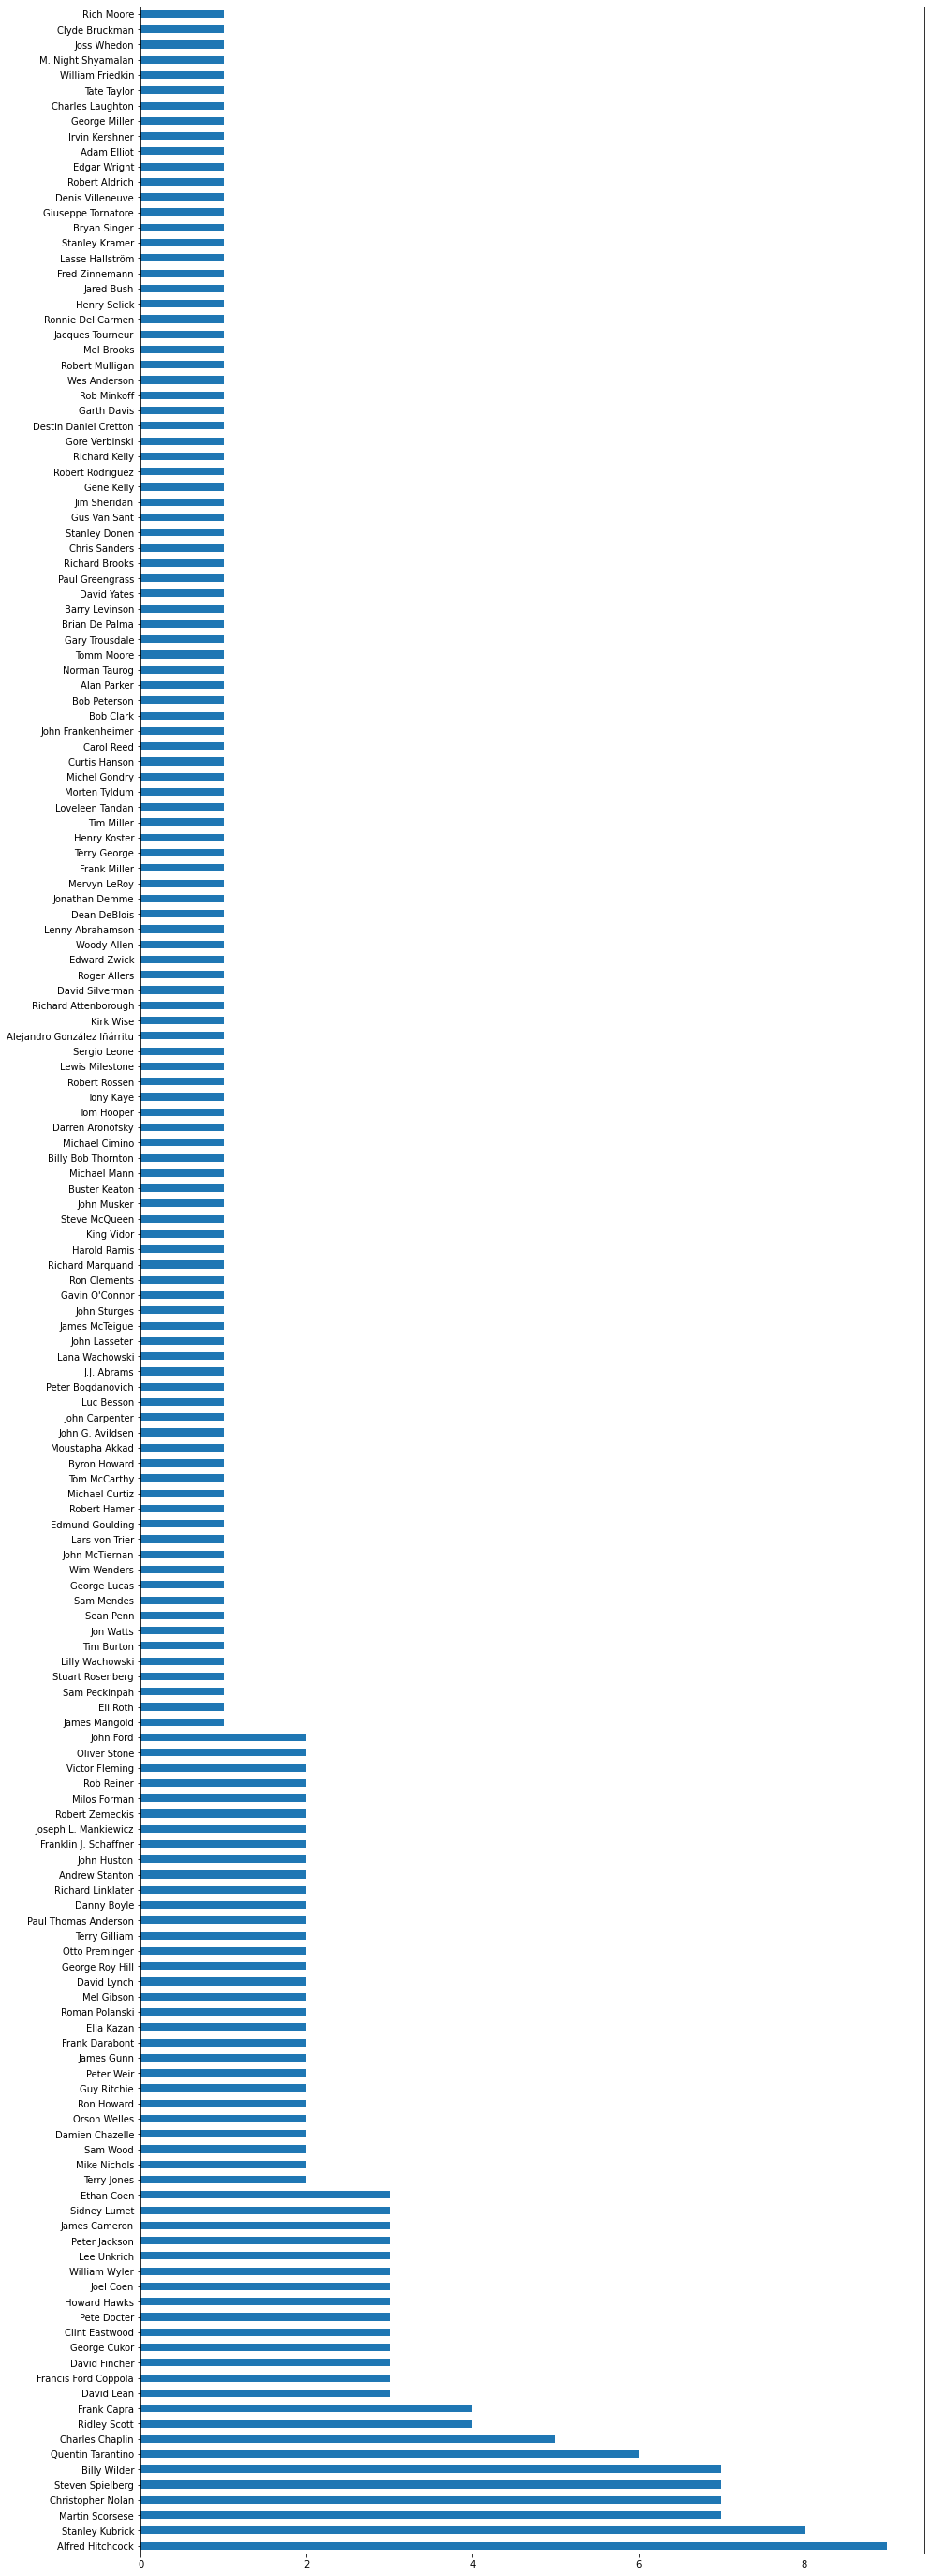

In [3]:
ax = data.plot(kind='barh', figsize=(15, 50),)

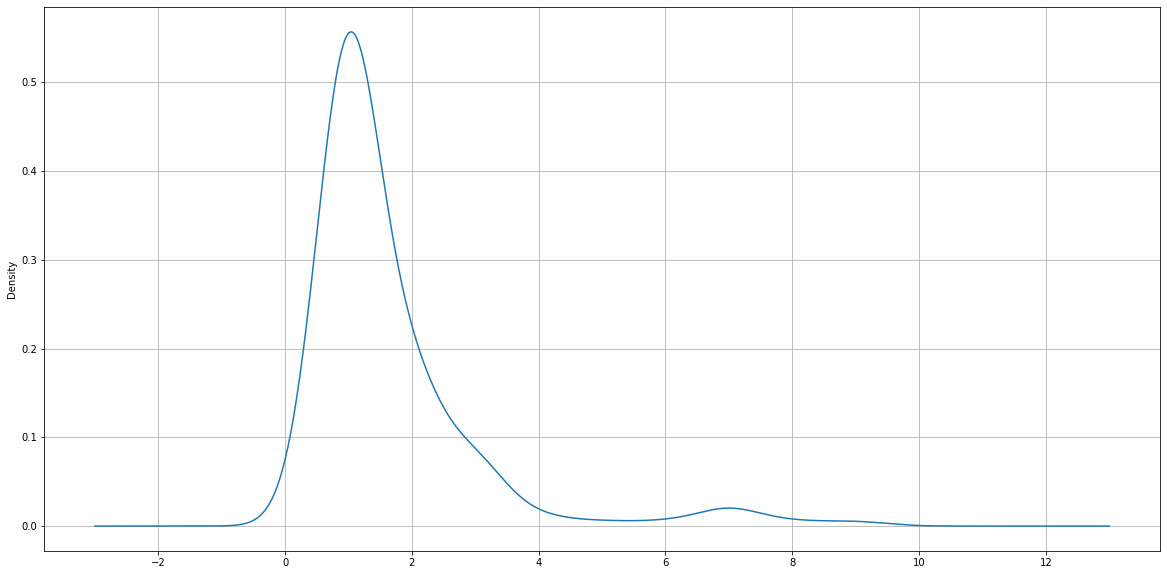

In [4]:
ax = data.plot.kde(figsize=(20, 10))
ax.ticklabel_format(style='plain', axis='y')
ax.grid('on', which='minor', axis='both' )
ax.grid('on', which='major', axis='both' )

In [5]:
x = g.query(
"""
SELECT ?actor (COUNT(?film) as ?num_films)
WHERE {
    ?film <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> schema:Movie ;
        schema:actor ?actor ;
        
    FILTER (STRLEN(?actor) > 0) .
} 
GROUP BY ?actor
ORDER BY DESC (?num_films)
LIMIT 150
""",
    initNs={'schema': SCHEMA, 'rdfs': RDFS}
)
data = pd.Series({actor.toPython(): num_films.toPython() for (actor, num_films) in x})

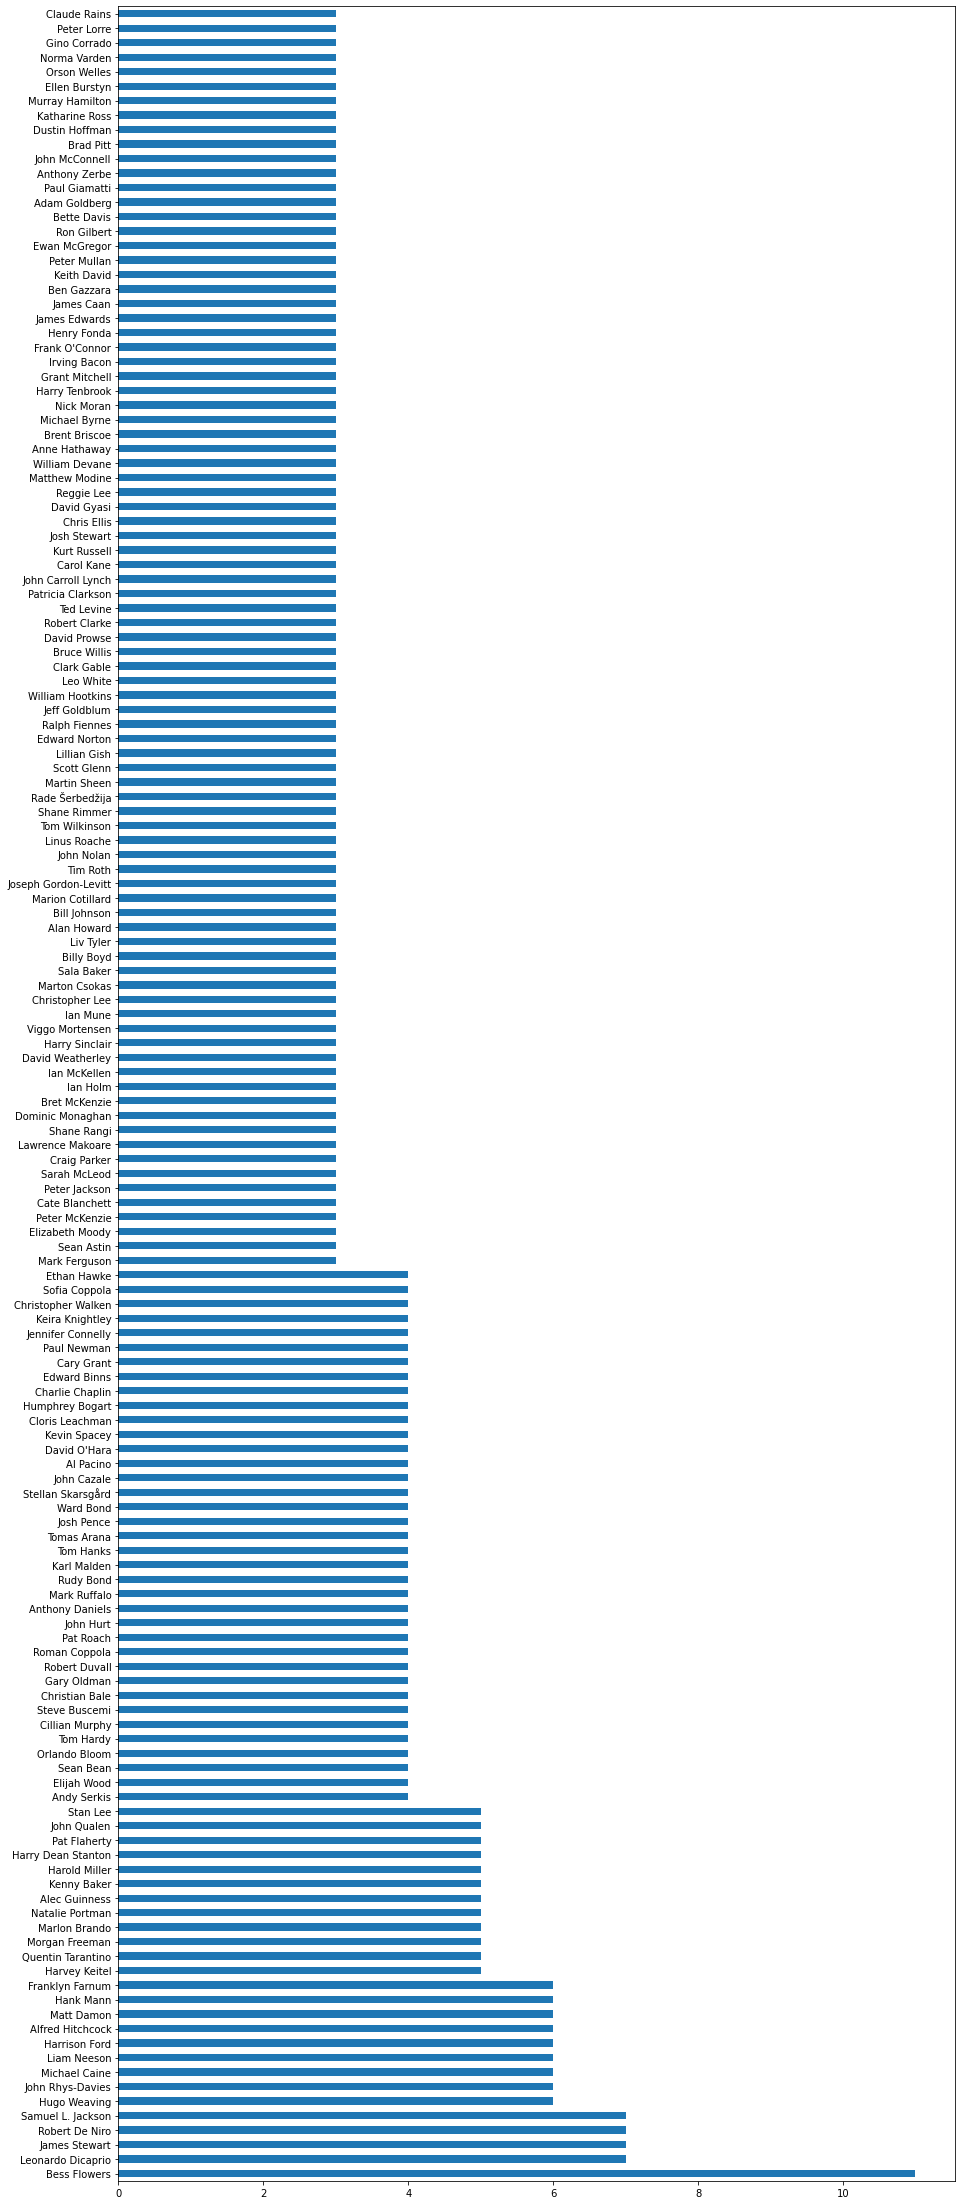

In [6]:
data.plot(kind='barh', figsize=(15, 40),)

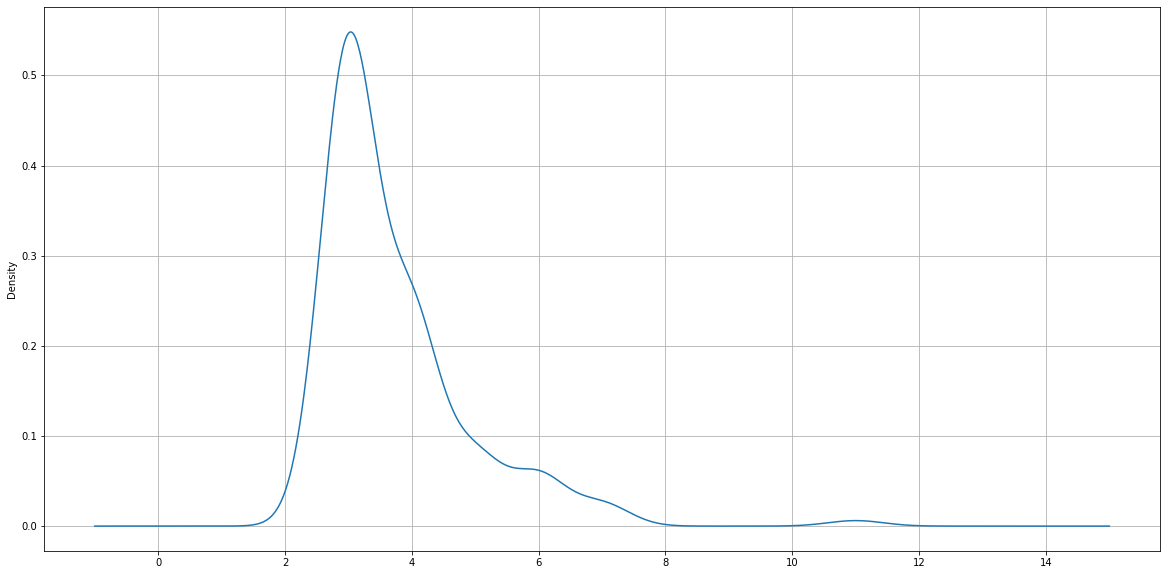

In [7]:
ax = data.plot.kde(figsize=(20, 10))
ax.ticklabel_format(style='plain', axis='y')
ax.grid('on', which='minor', axis='both' )
ax.grid('on', which='major', axis='both' )

# Does the number of received awards correlate with the BoxOffice/Cost value?

No it does not

In [8]:
x = g.query(
"""
SELECT ?film_name ?num_awards ?box_office ?cost
WHERE {
    ?film <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> schema:Movie ;
        dbo:num_awards ?num_awards ;
        dbo:box_office ?box_office ;
        dbo:cost ?cost ;
        schema:name ?film_name
} 
""",
    initNs={'schema': SCHEMA, 'rdfs': RDFS, 'dbo': DBO}
)
data = pd.DataFrame([{'film_name': film_name.toPython(), 'num_awards': num_awards.toPython(), 'box_office': box_office.toPython(), 'cost': cost.toPython()} for (film_name, num_awards, box_office, cost) in x])

In [9]:
data.corr('pearson')

num_awards  box_office      cost
num_awards    1.000000   -0.044420 -0.330644
box_office   -0.044420    1.000000  0.747124
cost         -0.330644    0.747124  1.000000

In [10]:
data.corr('spearman')

num_awards  box_office      cost
num_awards    1.000000   -0.081207 -0.330649
box_office   -0.081207    1.000000  0.738691
cost         -0.330649    0.738691  1.000000

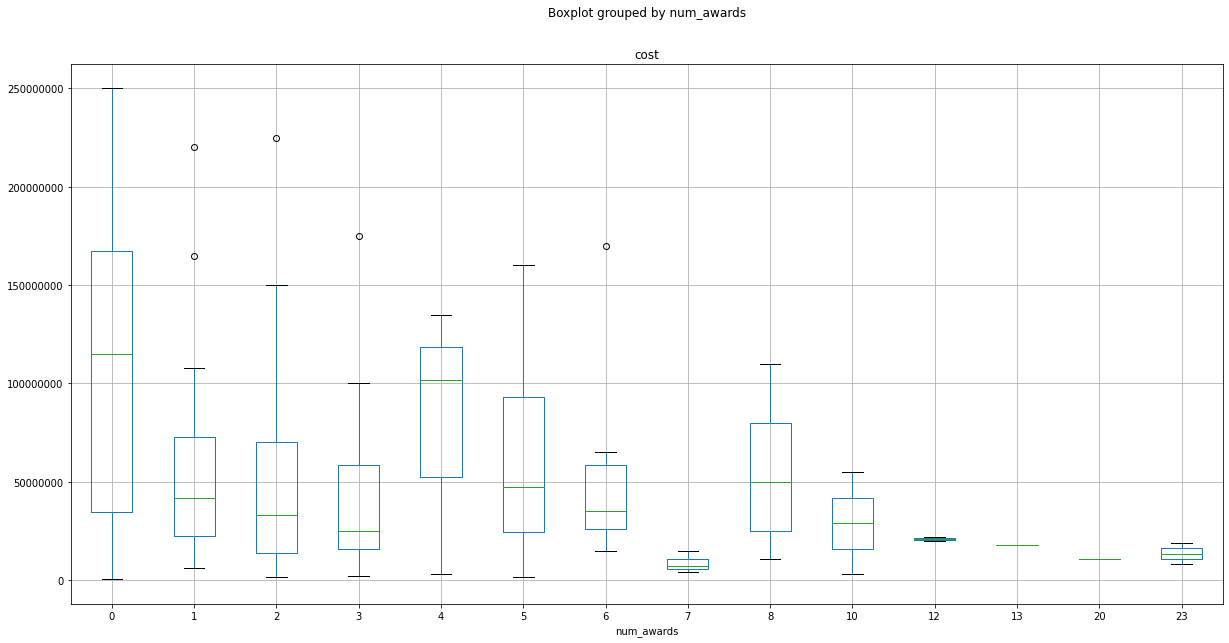

In [11]:
ax = data.boxplot(by='num_awards', column='cost', figsize=(20, 10), )
plt.xticks(rotation=0)
ax.ticklabel_format(style='plain', axis='y')

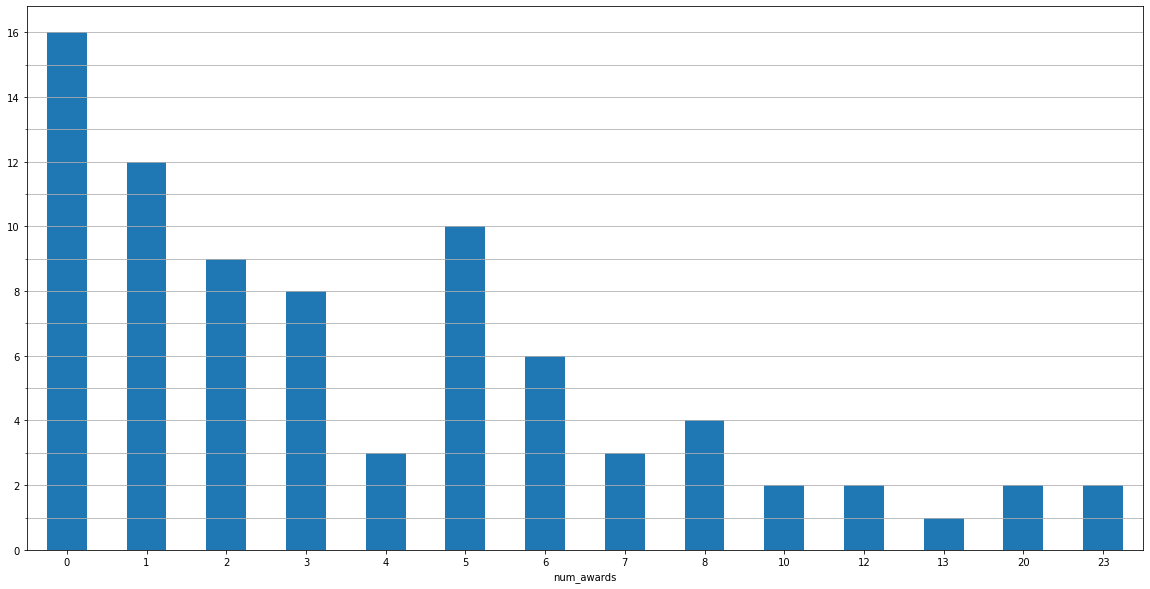

In [12]:
ax = data.groupby('num_awards')[['film_name']].count().plot.bar(figsize=(20, 10))
plt.xticks(rotation=0)
ytick = range(0, data.groupby('num_awards')[['film_name']].count().iloc[:, 0].max()+1)
ax.set_yticks(ytick, minor=True )
ax.grid('on', which='minor', axis='y' )
ax.grid('on', which='major', axis='y' )
ax.legend().remove()

# Which movie genre is most prominent in the the 250 movies?

In [13]:
x = g.query(
"""
SELECT ?genre (COUNT(?film) as ?num_films)
WHERE {
    ?film <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> schema:Movie ;
        schema:genre ?genre .
    
    FILTER (STRLEN(?genre) > 0) .
} 
GROUP BY ?genre
ORDER BY DESC (?num_films)
LIMIT 30
""",
    initNs={'dbo': DBO, 'foaf': FOAF, 'rdfs': RDFS, 'schema': SCHEMA}
)
data = pd.Series({genre.toPython(): num_films.toPython() for (genre, num_films) in x})

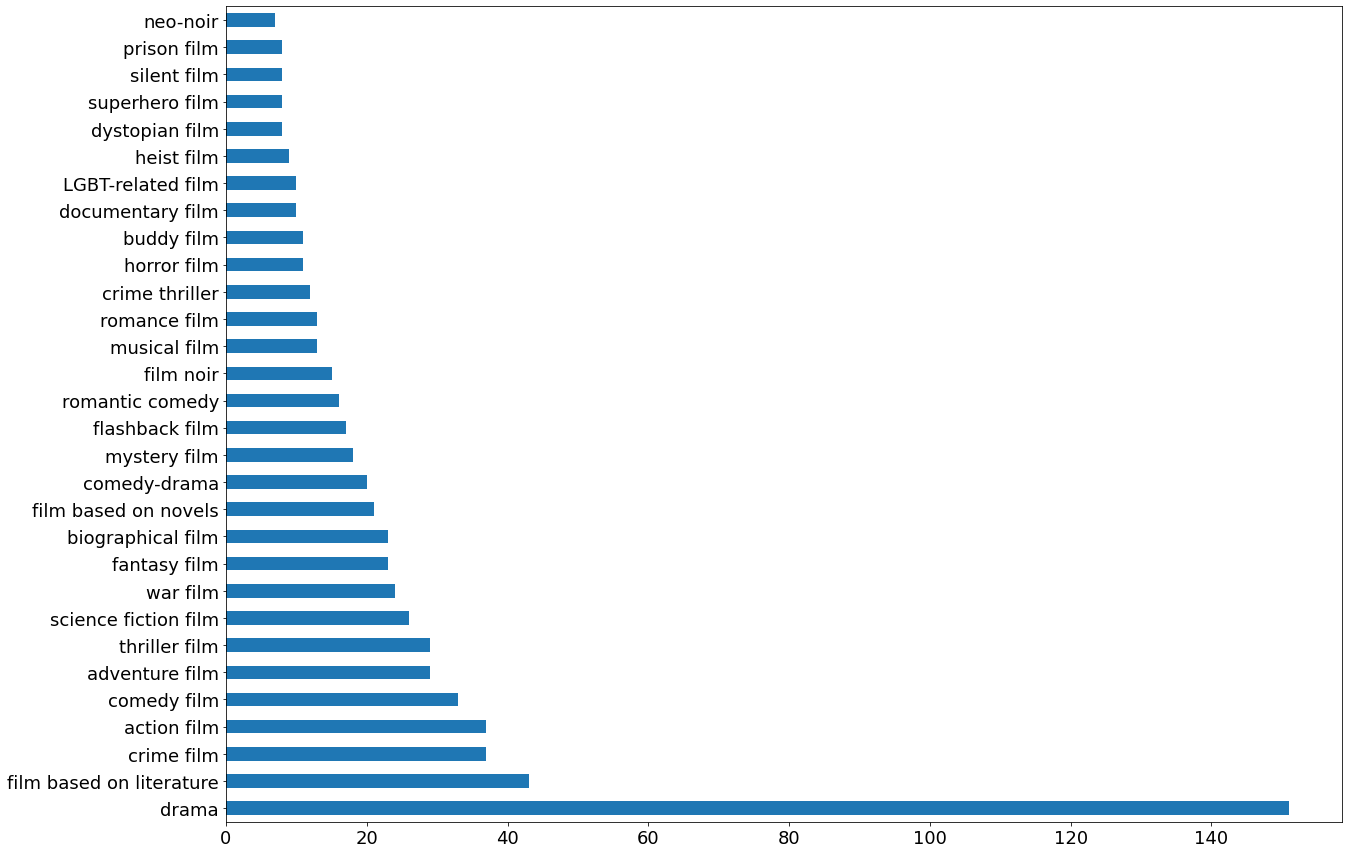

In [14]:
ax = data.plot(kind='barh', figsize=(20, 15),)
ax.tick_params(axis = 'both', which = 'major', labelsize = 18)

# How is the min/avg/max box_office per genre?

In [15]:
x = g.query(
"""
SELECT ?genre ?box_office ?cost
WHERE {
    ?film <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> schema:Movie ;
        schema:genre ?genre ;
        dbo:box_office ?box_office ;
        dbo:cost ?cost .
    
    FILTER (STRLEN(?genre) > 0) .
}

""",
    initNs={'dbo': DBO, 'rdfs': RDFS, 'schema': SCHEMA}
)
data = pd.DataFrame(
    {'genre': genre.toPython(), 'box_office': box_office.toPython(), 'cost': cost.toPython()}
    for (genre, box_office, cost) in x)

In [16]:
genres_count = data.groupby('genre').count()
relevant_genres = genres_count[genres_count > 10].dropna().index
relevant_genres

Index(['action film', 'adventure film', 'comedy film', 'crime film', 'drama',
       'fantasy film', 'film based on literature', 'film based on novels',
       'science fiction film', 'thriller film'],
      dtype='object', name='genre')

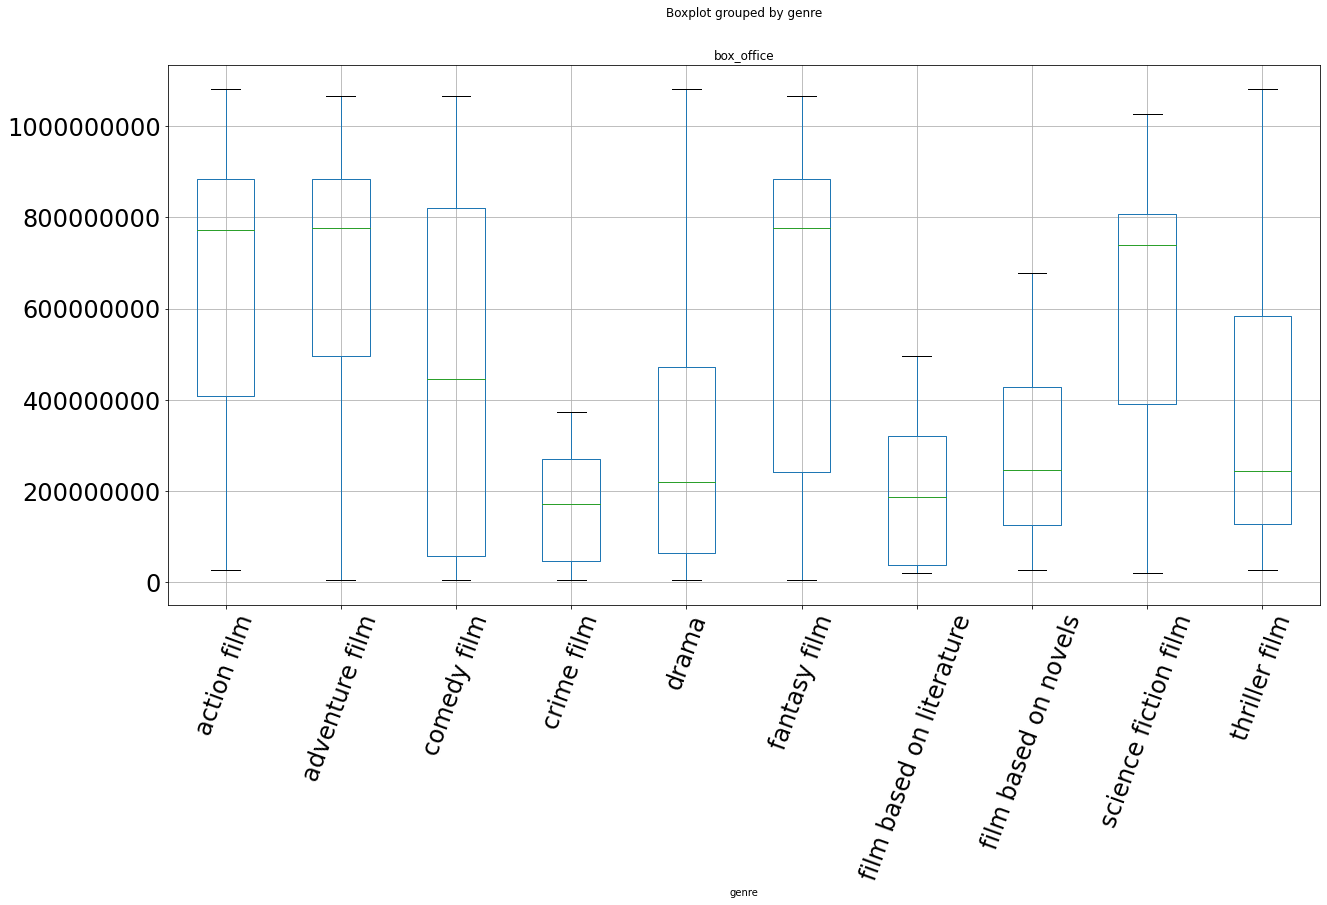

In [17]:
ax = data[data['genre'].isin(relevant_genres)].boxplot(by='genre', column='box_office', figsize=(20, 10),)
plt.xticks(rotation=70)
ax.ticklabel_format(style='plain', axis='y')
ax.tick_params(axis = 'both', which = 'major', labelsize = 24)

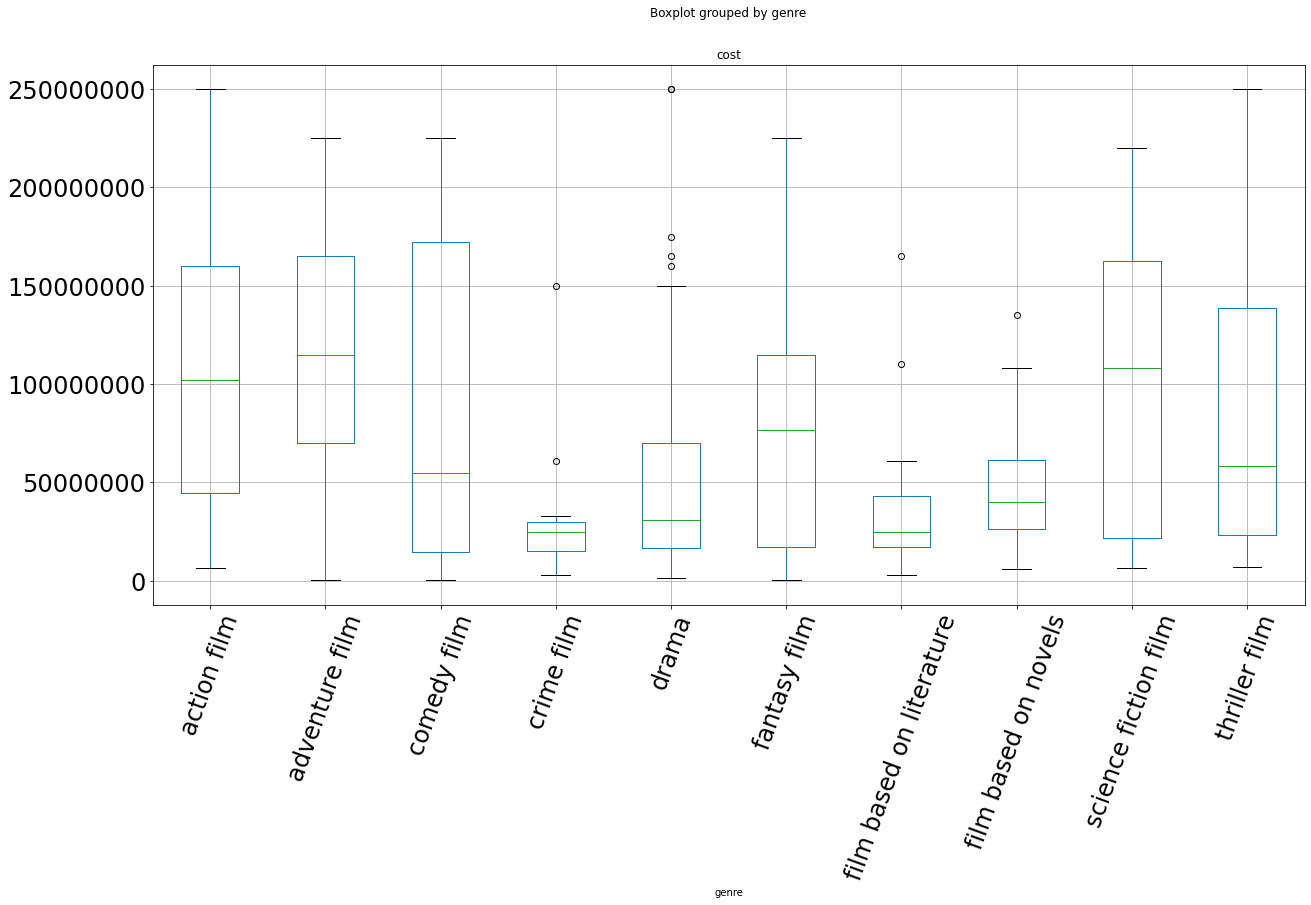

In [18]:
ax = data[data['genre'].isin(relevant_genres)].boxplot(by='genre', column='cost', figsize=(20, 10),)
plt.xticks(rotation=70)
ax.ticklabel_format(style='plain', axis='y')
ax.tick_params(axis = 'both', which = 'major', labelsize = 24)

# How do the box_office and cost of films relate?

In [19]:
x = g.query(
"""
SELECT ?box_office ?cost
WHERE {
    ?film <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> schema:Movie ;
        dbo:box_office ?box_office ;
        dbo:cost ?cost ;
} 
""",
    initNs={'schema': SCHEMA, 'rdfs': RDFS, 'dbo': DBO}
)
data = pd.DataFrame([{'box_office': box_office.toPython(), 'cost': cost.toPython()} for (box_office, cost) in x])

(array([-2.0e+08,  0.0e+00,  2.0e+08,  4.0e+08,  6.0e+08,  8.0e+08,
         1.0e+09,  1.2e+09]),
 <a list of 8 Text major ticklabel objects>)

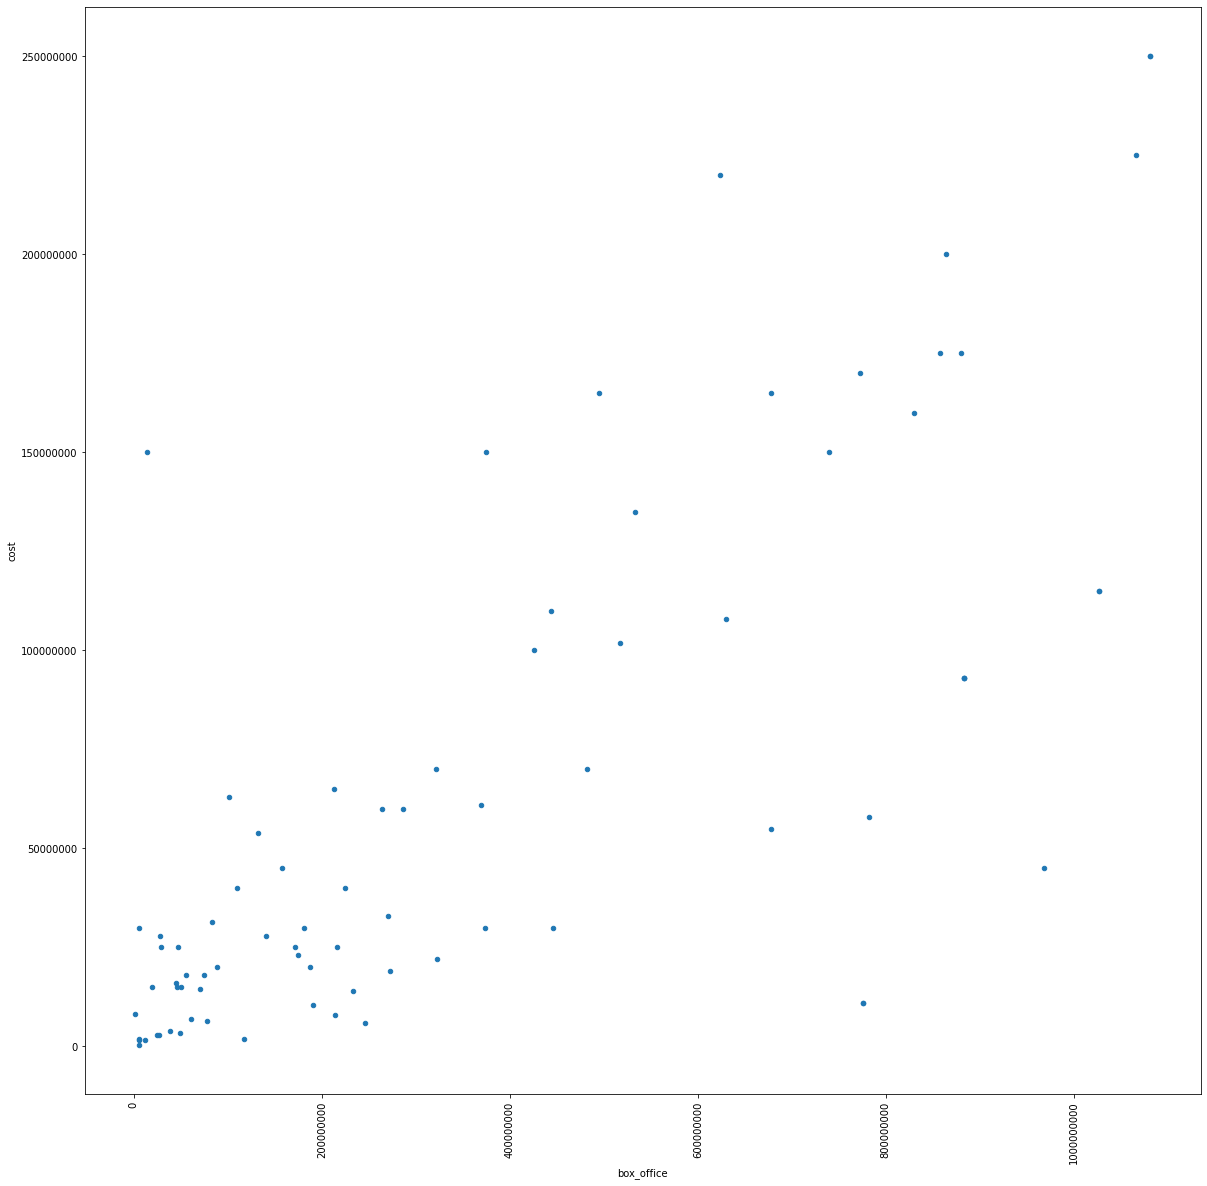

In [20]:
ax = data.plot(kind='scatter', x='box_office', y='cost', figsize=(20, 20),)
ax.ticklabel_format(useOffset=False)
ax.ticklabel_format(style='plain')
plt.xticks(rotation=90)

(array([-5.00e+08, -2.50e+08,  0.00e+00,  2.50e+08,  5.00e+08,  7.50e+08,
         1.00e+09,  1.25e+09,  1.50e+09,  1.75e+09]),
 <a list of 10 Text major ticklabel objects>)

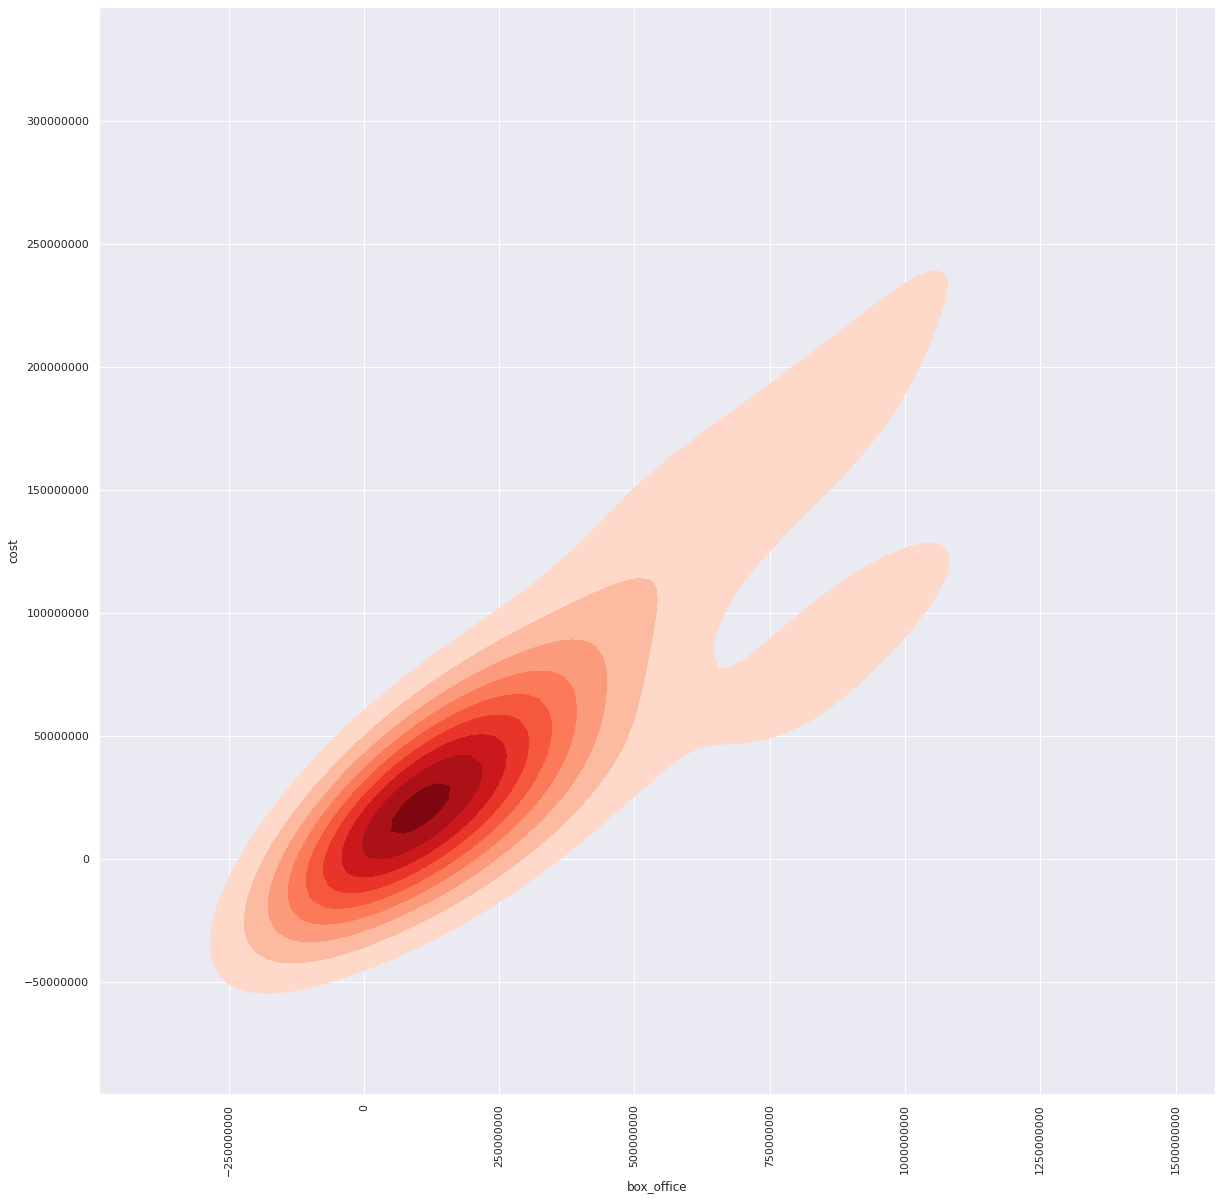

In [21]:
sns.set(rc={'figure.figsize':(20, 20)})
ax = sns.kdeplot(data['box_office'], data['cost'], color='r', shade=True, cmap="Reds", shade_lowest=False) 
ax.ticklabel_format(useOffset=False)
ax.ticklabel_format(style='plain')
plt.xticks(rotation=90)

# Does the number of actors correlate to the box_office of the film?

Very weakly

In [22]:
x = g.query(
"""
SELECT (COUNT(?actor) as ?actors) ?box_office ?cost
WHERE {
    ?film <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> schema:Movie ;
        schema:actor ?actor ;
        dbo:box_office ?box_office ;
        dbo:cost ?cost .
} GROUP BY ?film
""",
    initNs={'dbo': DBO, 'foaf': FOAF, 'rdfs': RDFS, 'schema': SCHEMA}
)
data = pd.DataFrame([{'actors': actors.toPython(), 'box_office': box_office.toPython(), 'cost': cost.toPython()} for (actors, box_office, cost) in x])

In [23]:
data.corr('pearson')

actors  box_office      cost
actors      1.000000    0.376721  0.336610
box_office  0.376721    1.000000  0.747124
cost        0.336610    0.747124  1.000000

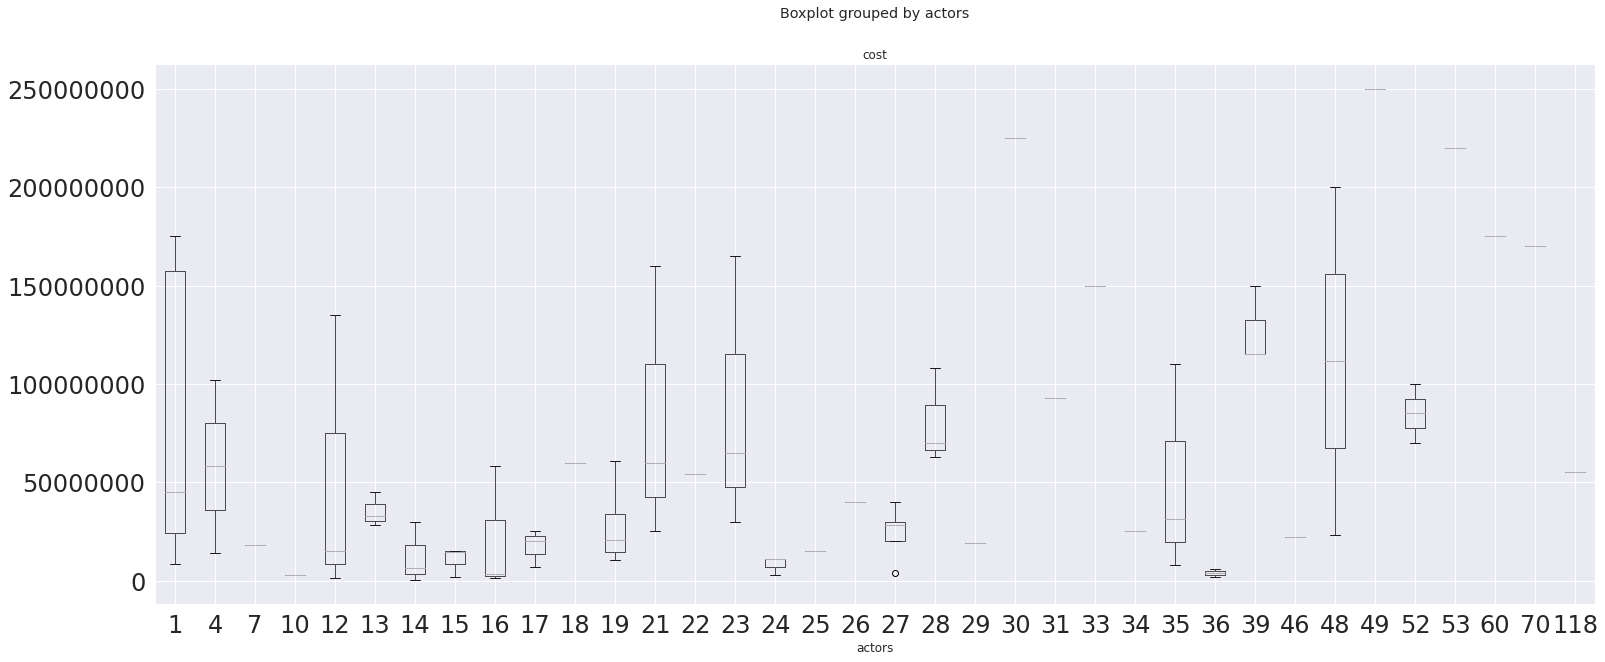

In [24]:
ax = data.boxplot(by='actors', column='cost', figsize=(25, 10),)
ax.ticklabel_format(style='plain', axis='y')
ax.tick_params(axis = 'both', which = 'major', labelsize = 24)

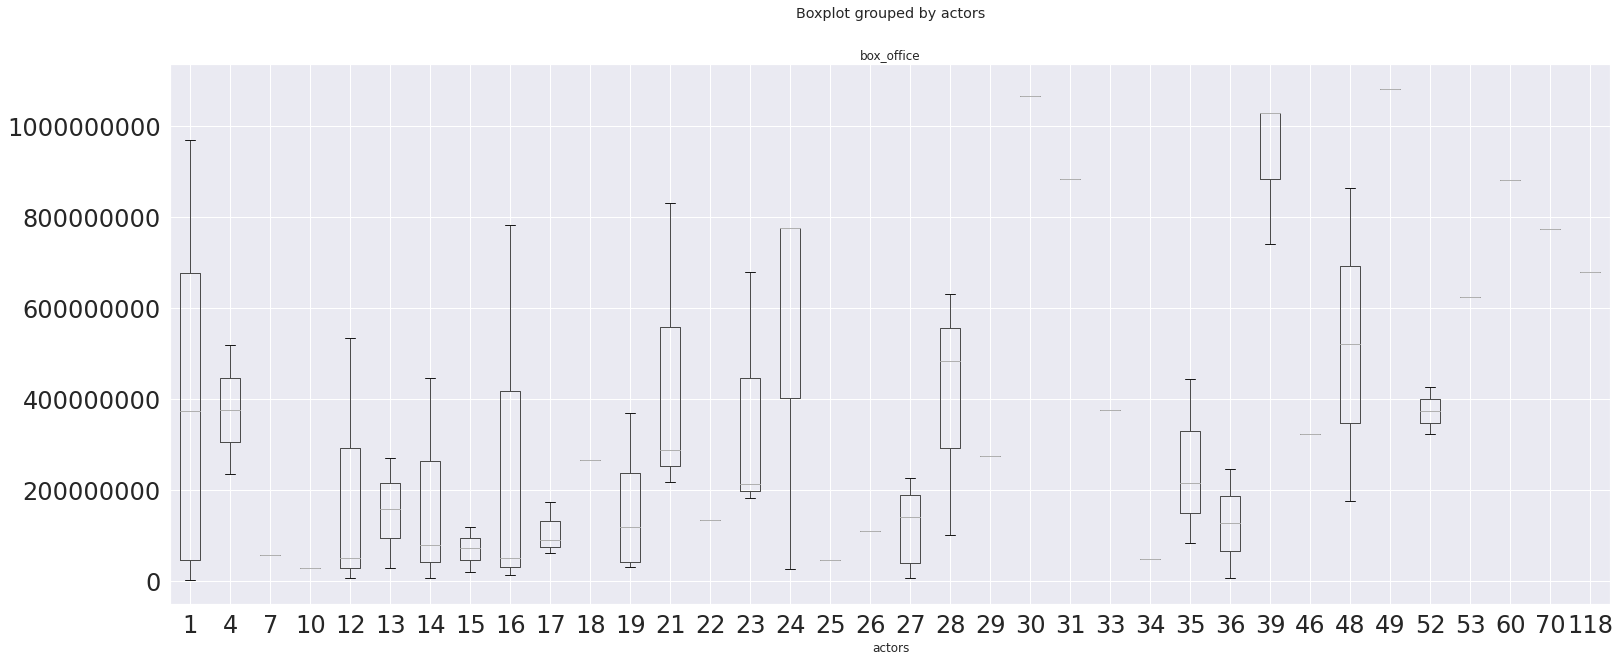

In [25]:
ax = data.boxplot(by='actors', column='box_office', figsize=(25, 10),)
ax.ticklabel_format(style='plain', axis='y')
ax.tick_params(axis = 'both', which = 'major', labelsize = 24)

In [26]:
x = g.query(
"""
SELECT ?film_name ?genre
WHERE {
    ?film <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> schema:Movie ;
        schema:name ?film_name ;
        schema:actor ?actor ;
        schema:genre ?genre .
} GROUP BY ?film
HAVING (COUNT(?actor) = 1)
""",
    initNs={'dbo': DBO, 'foaf': FOAF, 'rdfs': RDFS, 'schema': SCHEMA}
)
data = pd.DataFrame([{'film_name': film_name.toPython(), 'genres': genres.toPython()} for (film_name, genres) in x])

In [27]:
data

film_name            genres
0     Modern Times  documentary film
1             Room    romantic drama
2           Psycho  documentary film
3          Aladdin       comedy film
4             Rush  documentary film
5            Laura             drama
6   The Wild Bunch  documentary film
7          The Kid  documentary film
8              JFK  documentary film
9           Casino  documentary film
10       Notorious       silent film
11     The Message       silent film
12           Logan                  
13    The Exorcist       horror film
14     Sling Blade                  
15     The Shining             drama
16          Gandhi  documentary film

# How successfull are films by year? (by box_office)

In [28]:
x = g.query(
"""
SELECT ?year (AVG(?box_office) as ?bo_avg) (AVG(?cost) as ?cost_avg)
WHERE {
    ?film <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> schema:Movie ;
        schema:publishedDate ?year ;
        dbo:box_office ?box_office ;
        dbo:cost ?cost .
}
GROUP BY ?year
ORDER BY ?year
""",
    initNs={'dbo': DBO, 'foaf': FOAF, 'rdfs': RDFS, 'schema': SCHEMA}
)
data = pd.DataFrame(
    {'year': year.toPython(), 
     'box_office': bo.toPython(),
     'cost': cost.toPython()
    } for (year, bo, cost) in x)

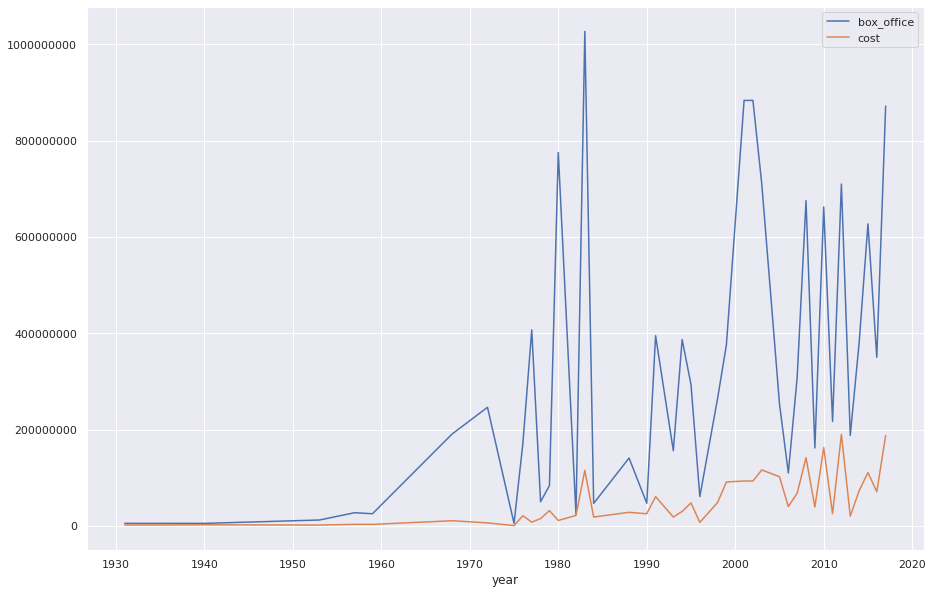

In [29]:
ax = data.plot(x='year', y=['box_office', 'cost'], figsize=(15, 10))
ax.ticklabel_format(style='plain', axis='y')

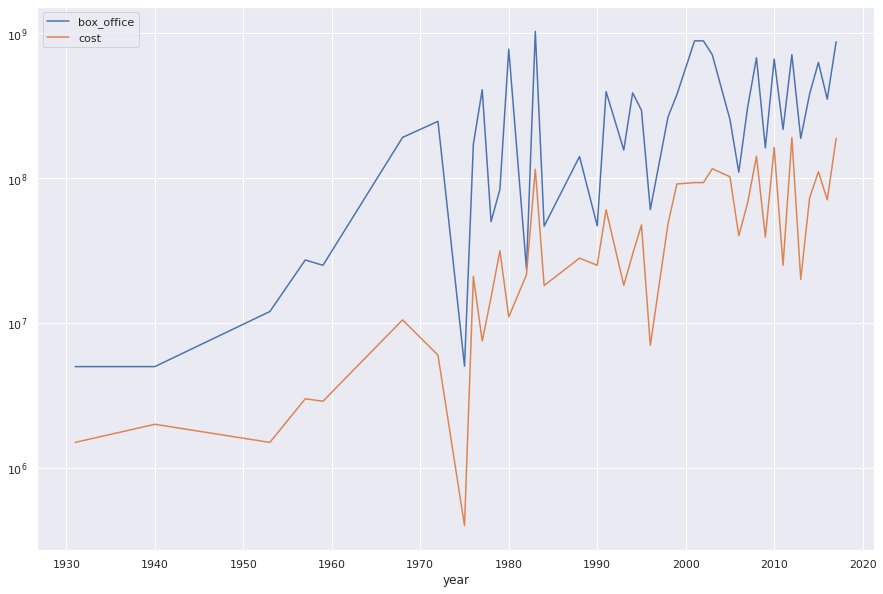

In [30]:
ax = data.plot(x='year', y=['box_office', 'cost'], figsize=(15, 10), logy=True)

# Which director has the highest cost films?

In [31]:
x = g.query(
"""
SELECT ?director_name ?cost
WHERE {
    ?film <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> schema:Movie ;
        schema:director ?director ;
        dbo:cost ?cost .
        
    ?director schema:name ?director_name
}
""",
    initNs={'dbo': DBO, 'foaf': FOAF, 'rdfs': RDFS, 'schema': SCHEMA}
)
data = pd.DataFrame({'director': director.toPython(), 'cost': cost.toPython()} for (director, cost) in x)

In [32]:
director_count = data.groupby('director').count()
relevant_director = director_count[director_count >= 2].dropna().index
relevant_director

Index(['Alfred Hitchcock', 'Billy Wilder', 'Charles Chaplin',
       'Christopher Nolan', 'Damien Chazelle', 'David Fincher', 'Ethan Coen',
       'Francis Ford Coppola', 'Frank Darabont', 'James Cameron', 'James Gunn',
       'Joel Coen', 'Martin Scorsese', 'Mel Gibson', 'Peter Jackson',
       'Quentin Tarantino', 'Ridley Scott', 'Sidney Lumet', 'Stanley Kubrick',
       'Steven Spielberg'],
      dtype='object', name='director')

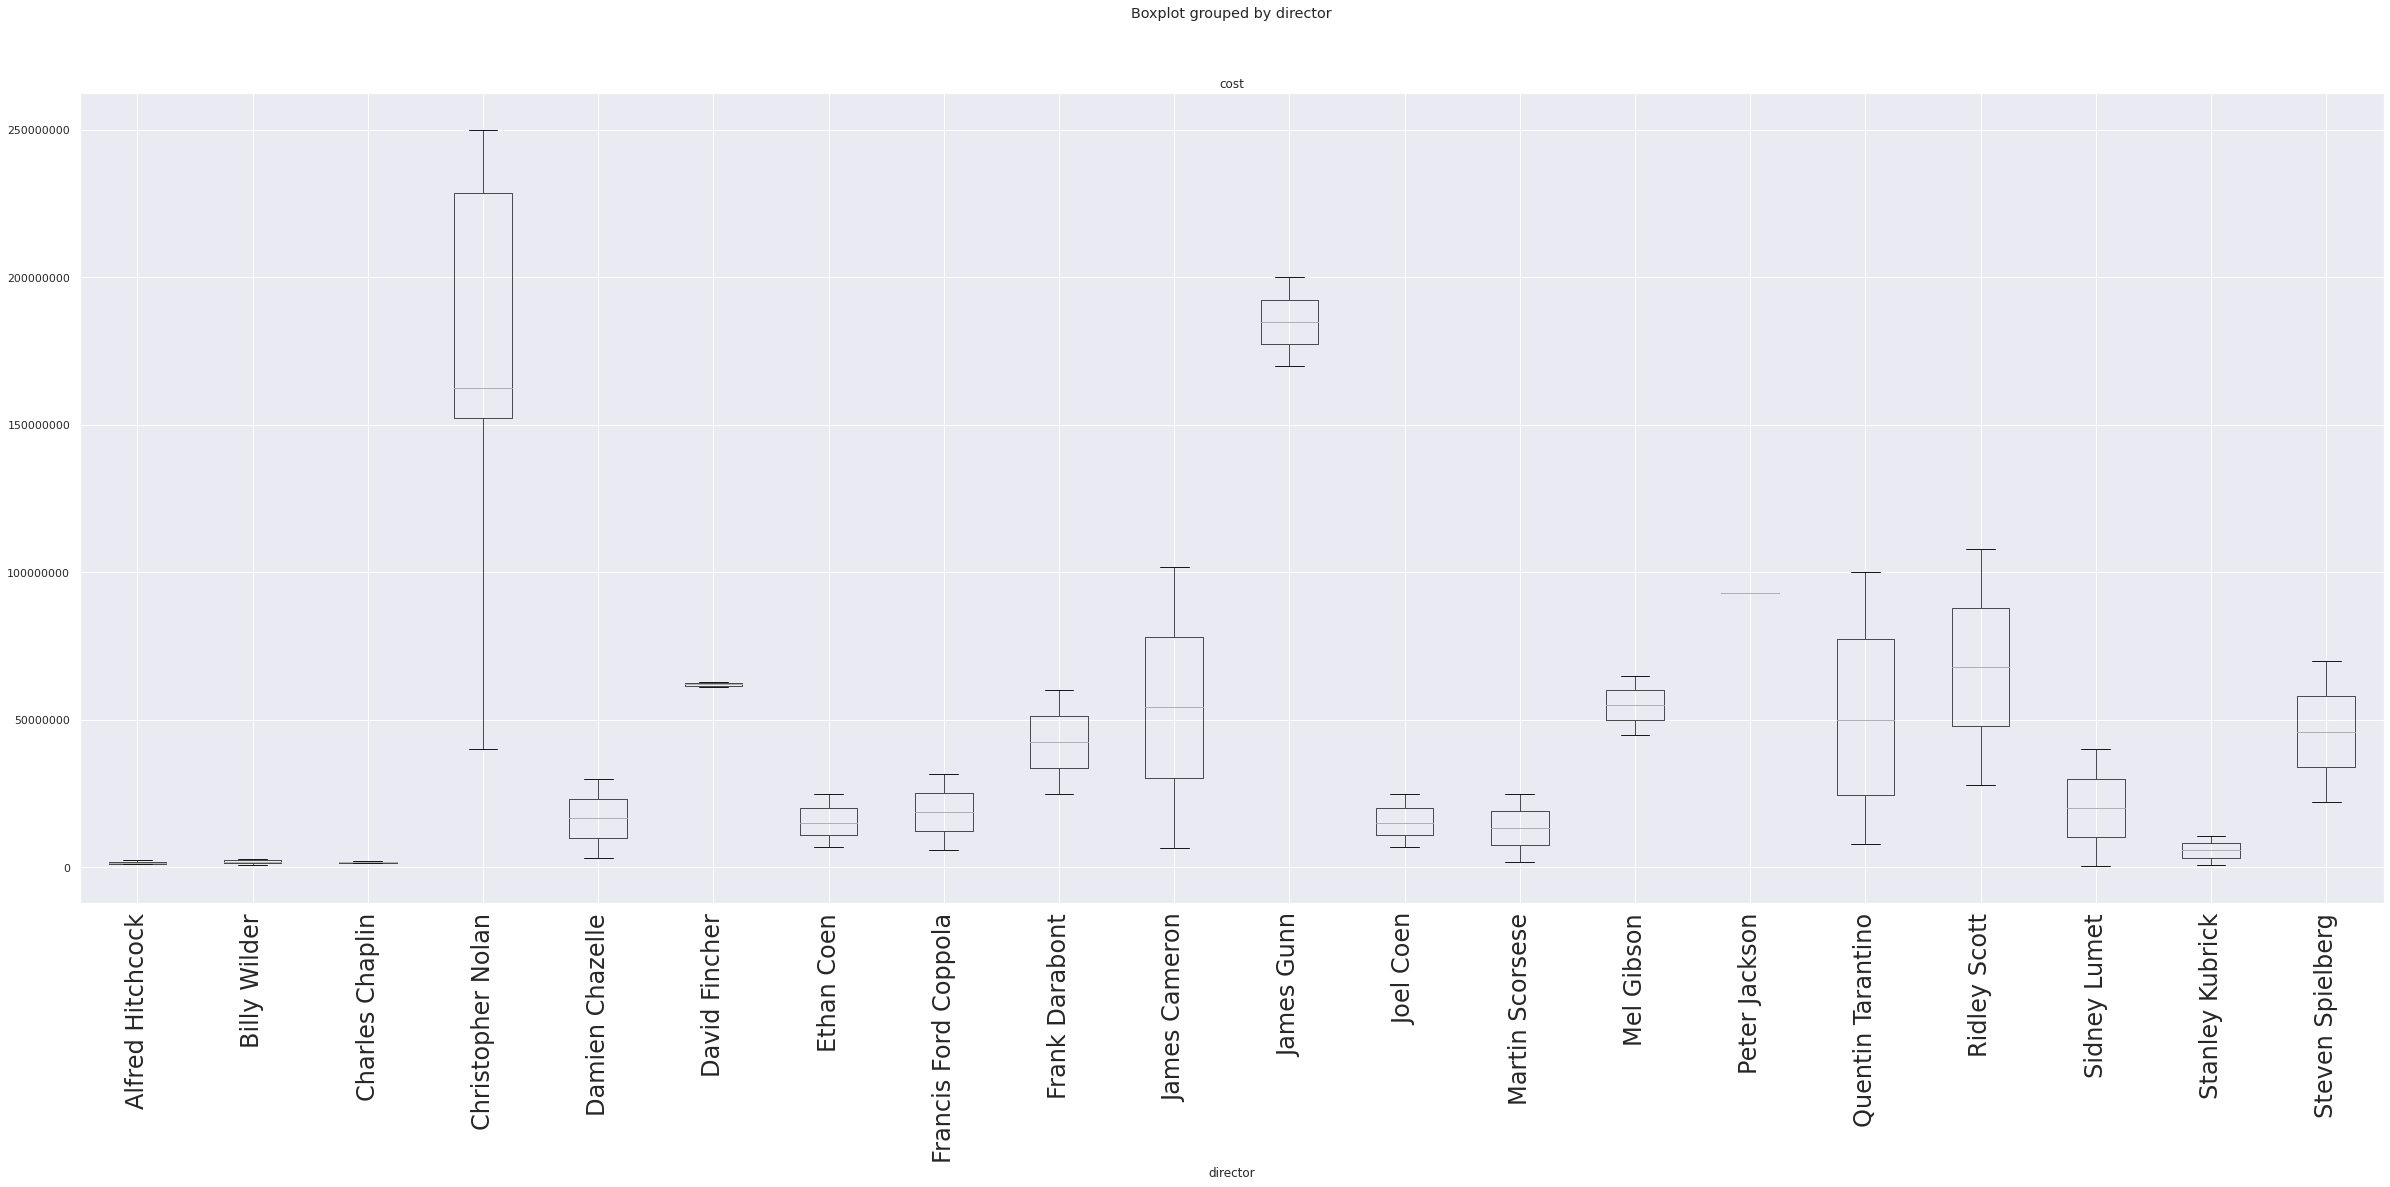

In [33]:
ax = data[data['director'].isin(relevant_director)].boxplot(by='director', column='cost', figsize=(40, 15),)
ax.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90)
ax.tick_params(axis = 'x', which = 'major', labelsize = 24)

# What is the relation between the actors & directors based on colaboration in movies?

In [34]:
x = g.query(
"""
SELECT ?director_name (COUNT(?actor_name) as ?actor_name)
WHERE {
    ?film <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> schema:Movie ;
        schema:director ?director ;
        schema:actor ?actor_name .
        
    ?director schema:name ?director_name
}
GROUP BY ?film
""",
    initNs={'dbo': DBO, 'foaf': FOAF, 'rdfs': RDFS, 'schema': SCHEMA}
)
data = pd.DataFrame({'director': director.toPython(), 'actor': actor.toPython()} for (director, actor) in x)

In [35]:
director_count = data.groupby('director').count()
relevant_director = director_count[director_count > 1].dropna().index
relevant_director

Index(['Alfred Hitchcock', 'Billy Wilder', 'Charles Chaplin',
       'Christopher Nolan', 'Clint Eastwood', 'Damien Chazelle', 'Danny Boyle',
       'David Fincher', 'David Lean', 'David Lynch', 'Elia Kazan',
       'Ethan Coen', 'Francis Ford Coppola', 'Frank Capra', 'Frank Darabont',
       'Franklin J. Schaffner', 'George Roy Hill', 'Guy Ritchie',
       'Howard Hawks', 'James Cameron', 'James Gunn', 'John Ford',
       'John Huston', 'Joseph L. Mankiewicz', 'Martin Scorsese', 'Mel Gibson',
       'Mike Nichols', 'Milos Forman', 'Oliver Stone', 'Orson Welles',
       'Otto Preminger', 'Paul Thomas Anderson', 'Peter Jackson', 'Peter Weir',
       'Quentin Tarantino', 'Richard Linklater', 'Ridley Scott', 'Rob Reiner',
       'Robert Zemeckis', 'Roman Polanski', 'Ron Howard', 'Sidney Lumet',
       'Stanley Kubrick', 'Steven Spielberg', 'William Wyler'],
      dtype='object', name='director')

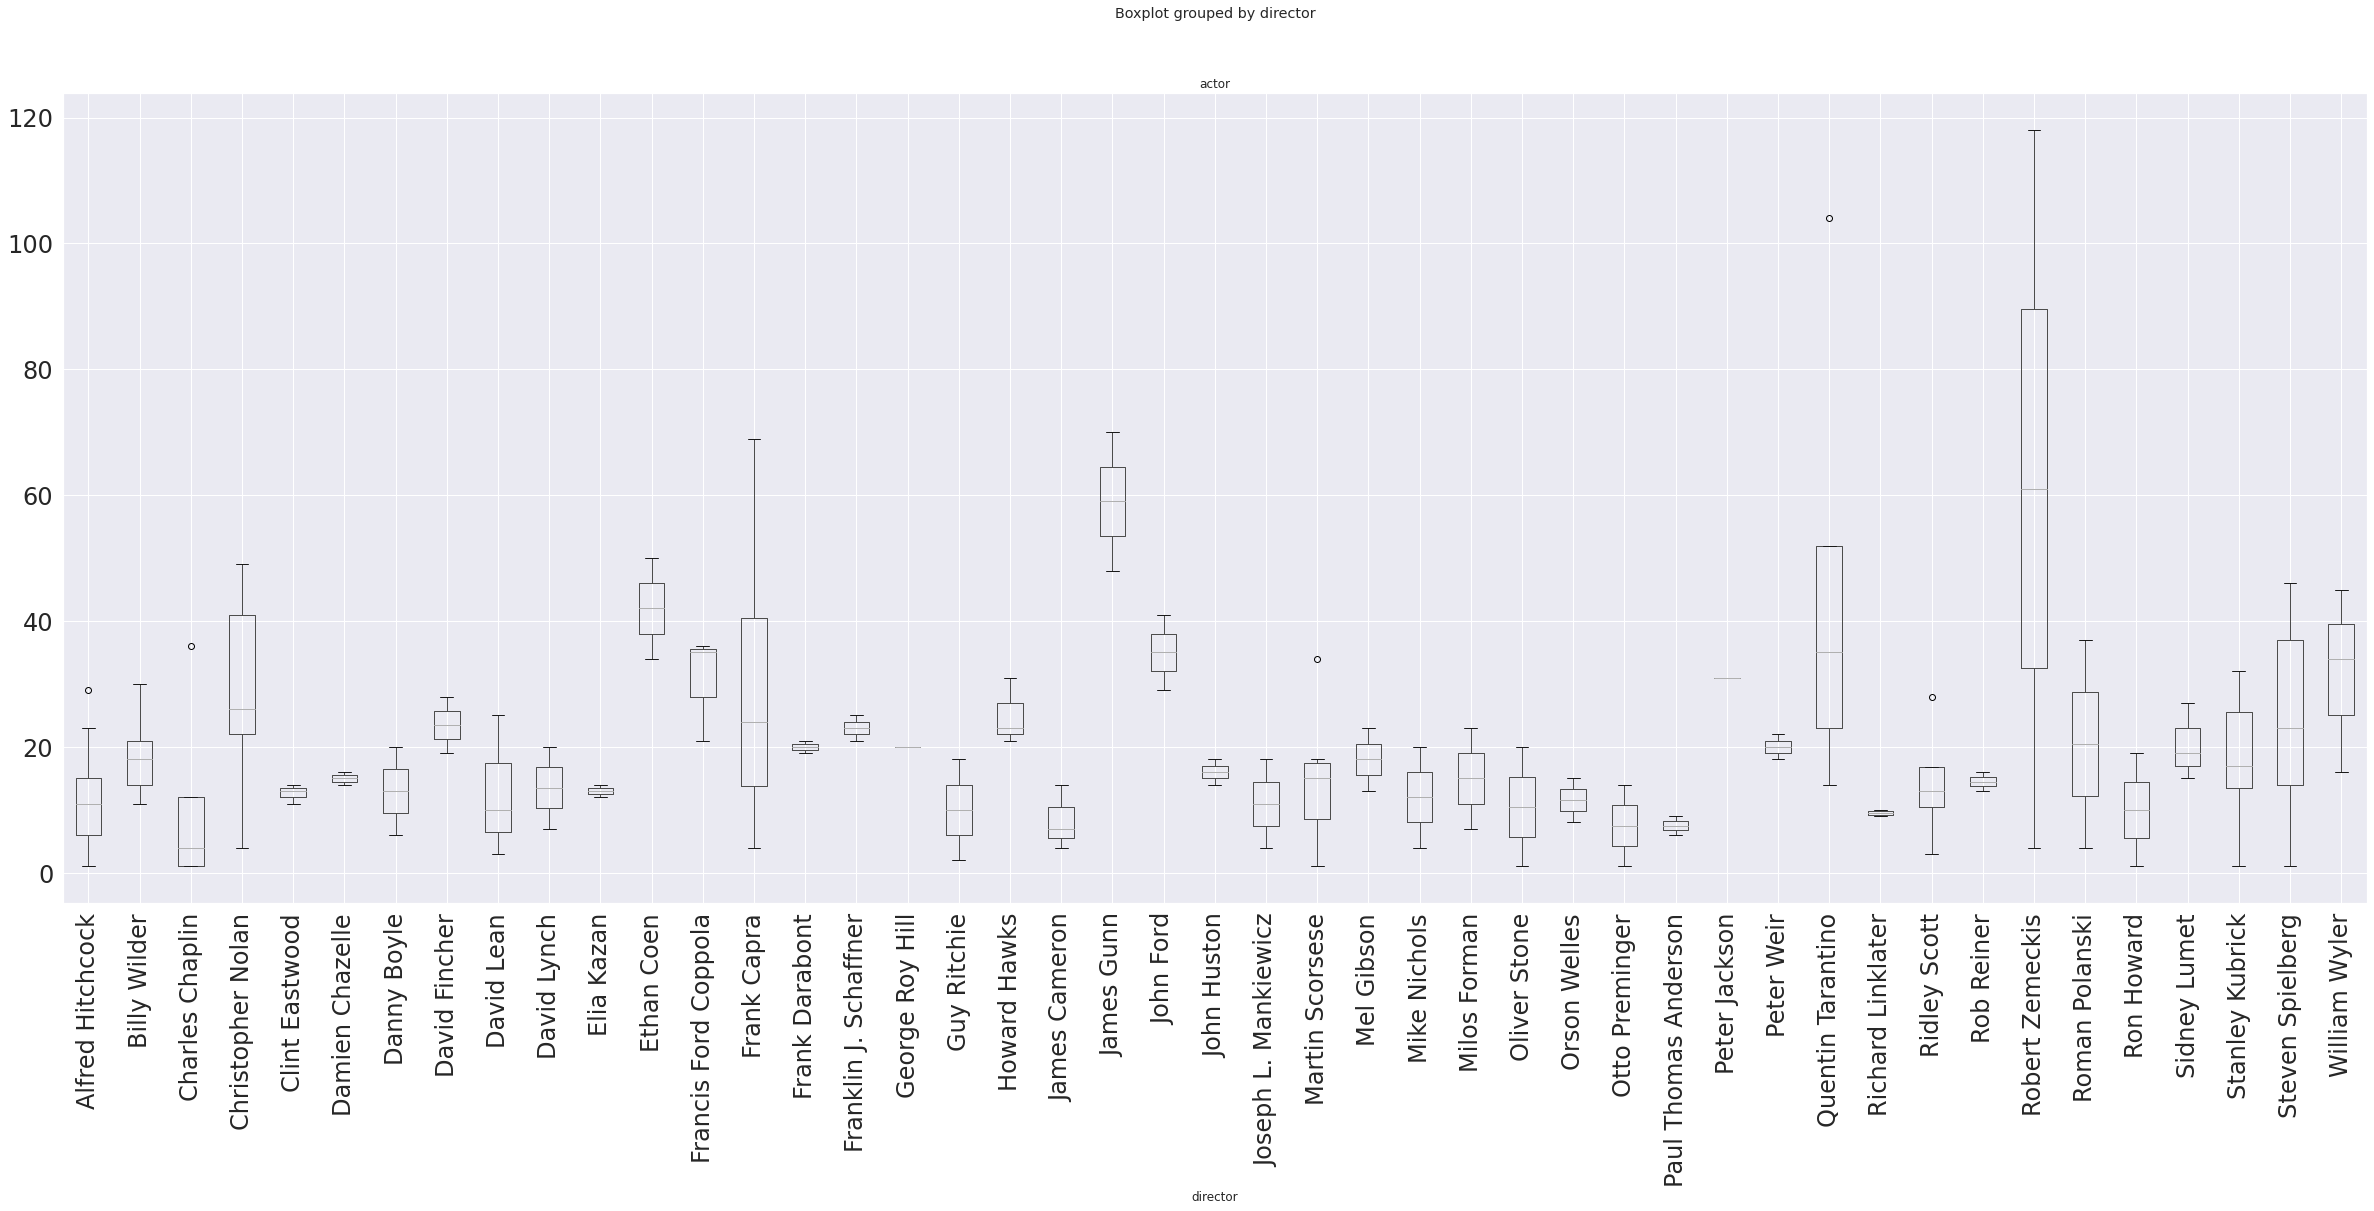

In [36]:
ax = data[data['director'].isin(relevant_director)].boxplot(by='director', column='actor', figsize=(40, 15),)
ax.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90)
ax.tick_params(axis = 'both', which = 'major', labelsize = 24)